# **Project Overview**

The primary goal of this project is to build a predictive model that evaluates the likelihood of default for customers of a Taiwan-based credit card issuer. By leveraging historical data, the model aims to offer valuable insights into the crucial factors influencing default risk. The outcomes of this predictive analysis will empower the credit card issuer to make well-informed decisions regarding credit card approvals, setting appropriate credit limits, and refining customer segmentation strategies.



#**Problem Statement**
Credit cards are vital tools for financial institutions, particularly banks, providing individuals with temporary access to bank funds. Upon accepting a credit card, cardholders commit to settling bills by the specified due date; failure results in a credit card default. When customers can't repay loans, and the bank foresees difficulty in collecting, it may attempt to sell the loan. If selling is challenging, the debt is written off, leading to a charge-off. Charge-offs pose significant financial losses for banks, impacting customer credit ratings. This project aims to build a machine learning model predicting individuals prone to credit card default, offering proactive risk management insights for banks to reduce financial losses and protect both customers and the institution's credit ratings.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Accessing the folder
folder_path = '/content/drive/MyDrive/credit-stability-model'

# Listing files in the folder
import os
os.listdir(folder_path)


['.ipynb_checkpoints', '.git', 'data.xls', 'Untitled.ipynb']

In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=ba7f46c9f700a52f453a8c521546ef915441210a356535dbe57e915d63593922
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.classification import LogisticRegression as SparkLR
from pyspark.ml.feature import StandardScaler as SparkScaler,VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline as SparkPipe


In [ ]:
spark = SparkSession.builder.master('local').getOrCreate()

In [ ]:
import pandas as pd

# Specify the file path
file_path = '/content/drive/MyDrive/credit-stability-model/data.xls'

# Read the Excel file
df = pd.read_excel(file_path, skiprows=[0])

# Display the first few rows of the DataFrame
df.head()






,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
# Creating a spark df
spark_df = spark.createDataFrame(df)
spark_df.show(5)


+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

In [ ]:
#training, test = spark_df.randomSplit([0.75,0.25])

In [ ]:
spark_df.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [ ]:
# Display the first 5 records
spark_df.head(5)

[Row(ID=1, LIMIT_BAL=20000, SEX=2, EDUCATION=2, MARRIAGE=1, AGE=24, PAY_0=2, PAY_2=2, PAY_3=-1, PAY_4=-1, PAY_5=-2, PAY_6=-2, BILL_AMT1=3913, BILL_AMT2=3102, BILL_AMT3=689, BILL_AMT4=0, BILL_AMT5=0, BILL_AMT6=0, PAY_AMT1=0, PAY_AMT2=689, PAY_AMT3=0, PAY_AMT4=0, PAY_AMT5=0, PAY_AMT6=0, default payment next month=1),
 Row(ID=2, LIMIT_BAL=120000, SEX=2, EDUCATION=2, MARRIAGE=2, AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682, BILL_AMT2=1725, BILL_AMT3=2682, BILL_AMT4=3272, BILL_AMT5=3455, BILL_AMT6=3261, PAY_AMT1=0, PAY_AMT2=1000, PAY_AMT3=1000, PAY_AMT4=1000, PAY_AMT5=0, PAY_AMT6=2000, default payment next month=1),
 Row(ID=3, LIMIT_BAL=90000, SEX=2, EDUCATION=2, MARRIAGE=2, AGE=34, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=29239, BILL_AMT2=14027, BILL_AMT3=13559, BILL_AMT4=14331, BILL_AMT5=14948, BILL_AMT6=15549, PAY_AMT1=1518, PAY_AMT2=1500, PAY_AMT3=1000, PAY_AMT4=1000, PAY_AMT5=1000, PAY_AMT6=5000, default payment next month=0),
 Ro

Lets check on the data types of the features in this data


In [ ]:
# Print out the schema
spark_df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- LIMIT_BAL: long (nullable = true)
 |-- SEX: long (nullable = true)
 |-- EDUCATION: long (nullable = true)
 |-- MARRIAGE: long (nullable = true)
 |-- AGE: long (nullable = true)
 |-- PAY_0: long (nullable = true)
 |-- PAY_2: long (nullable = true)
 |-- PAY_3: long (nullable = true)
 |-- PAY_4: long (nullable = true)
 |-- PAY_5: long (nullable = true)
 |-- PAY_6: long (nullable = true)
 |-- BILL_AMT1: long (nullable = true)
 |-- BILL_AMT2: long (nullable = true)
 |-- BILL_AMT3: long (nullable = true)
 |-- BILL_AMT4: long (nullable = true)
 |-- BILL_AMT5: long (nullable = true)
 |-- BILL_AMT6: long (nullable = true)
 |-- PAY_AMT1: long (nullable = true)
 |-- PAY_AMT2: long (nullable = true)
 |-- PAY_AMT3: long (nullable = true)
 |-- PAY_AMT4: long (nullable = true)
 |-- PAY_AMT5: long (nullable = true)
 |-- PAY_AMT6: long (nullable = true)
 |-- default payment next month: long (nullable = true)



Some features SEX,EDUCATION and MARRIAGE  need to be converted to categorical for easy data analysis

In [ ]:

from pyspark.sql.functions import when, col

# Replace 'your_spark_df' and 'SEX' with the actual DataFrame and column names
spark_df = spark_df.withColumn("SEX_cat", when(col("SEX") == 1, "male").when(col("SEX") == 2, "female").otherwise("unknown"))

# Show the updated DataFrame
spark_df.show(5)



+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+-------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|SEX_cat|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+-------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1| female|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|

In [ ]:
spark_df.select("SEX", "SEX_cat").show(5)




+---+-------+
|SEX|SEX_cat|
+---+-------+
|  2| female|
|  2| female|
|  2| female|
|  2| female|
|  1|   male|
+---+-------+
only showing top 5 rows



In [ ]:
spark_df.select("MARRIAGE").distinct().show()


+--------+
|MARRIAGE|
+--------+
|       0|
|       1|
|       3|
|       2|
+--------+



In [ ]:
# Converting Marriage to 1 marriage, 2= single, 0, uknown and 3 others
spark_df = spark_df.withColumn("MARRIAGE_cat",
                               when(col("MARRIAGE") == 1, "marriage")
                               .when(col("MARRIAGE") == 2, "single")
                               .when(col("MARRIAGE") == 0, "unknown")
                               .otherwise("others"))

# Show the updated DataFrame
spark_df.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+-------+------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|SEX_cat|MARRIAGE_cat|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+-------+------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1| female|    marriage|
|  2|   120000|  2|        2|       

In [ ]:
spark_df.select('MARRIAGE','MARRIAGE_cat').show(5)

+--------+------------+
|MARRIAGE|MARRIAGE_cat|
+--------+------------+
|       1|    marriage|
|       2|      single|
|       2|      single|
|       1|    marriage|
|       1|    marriage|
+--------+------------+
only showing top 5 rows



In [ ]:
# Dealing with Education
spark_df = spark_df.withColumn("EDUCATION_category",
                               when(col("EDUCATION") == 1, "graduate")
                               .when(col("EDUCATION") == 2, "university")
                               .when(col("EDUCATION") == 3, "high school")
                               .when(col("EDUCATION") == 4, "others")
                               .when(col("EDUCATION") == 5, "unknown")
                               .when(col("EDUCATION") == 6, "unknown")
                               .otherwise("unknown"))

# Show the updated DataFrame
spark_df.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+-------+------------+------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|SEX_cat|MARRIAGE_cat|EDUCATION_category|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+-------+------------+------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1| 

In [ ]:
spark_df.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'SEX_cat',
 'MARRIAGE_cat',
 'EDUCATION_category']

In [ ]:
# Let me drop one column for SEX since they are the same
column_to_drop = 'SEX_category'
spark_df = spark_df.drop(column_to_drop)
spark_df.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'SEX_cat',
 'MARRIAGE_cat',
 'EDUCATION_category']

# **Exploratory Data Analysis**

+------------------+-----+
|EDUCATION_category|count|
+------------------+-----+
|          graduate|10585|
|        university|14030|
|           unknown|  345|
|            others|  123|
|       high school| 4917|
+------------------+-----+



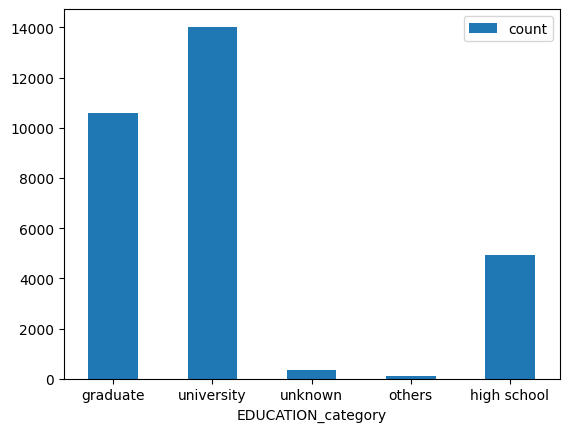

In [ ]:
# Create bar plot of EDUCATION
# First, aggregate data
education_cats = spark_df.groupBy('EDUCATION_category').count()
education_cats.show()
# Then plot data
education_cats.toPandas().plot(x="EDUCATION_category", y="count", kind="bar", rot=0);


+------------+-----+
|MARRIAGE_cat|count|
+------------+-----+
|    marriage|13659|
|     unknown|   54|
|      others|  323|
|      single|15964|
+------------+-----+



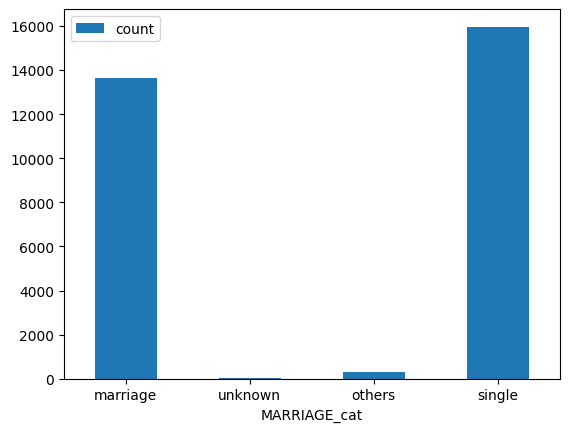

In [ ]:
# Create bar plot of MARRIAGE
# First, aggregate data
marriage_cats = spark_df.groupby('MARRIAGE_cat').count()
marriage_cats.show()
# Then plot data
marriage_cats.toPandas().plot(x="MARRIAGE_cat", y="count", kind="bar", rot=0);

In [ ]:
from pyspark.sql import functions as F
# Bin EDUCATION categories
df_education_binned = spark_df.withColumn('EDUCATION',
                                          F.when(spark_df['EDUCATION_category'] == '0', 'Other')\
                                          .when(spark_df['EDUCATION_category'] == '5', 'Other')\
                                          .when(spark_df['EDUCATION_category'] == '6', 'Other')\
                                          .otherwise(spark_df['EDUCATION_category'])
                                         )
# Bin MARRIAGE categories
df_all_binned = df_education_binned.withColumn('MARRIAGE_cat',
                                               F.when(df_education_binned['MARRIAGE_cat'] == '0', 'Other')\
                                               .when(df_education_binned['MARRIAGE_cat']== "3", "other")
                                               .otherwise(df_education_binned['MARRIAGE_cat'])
                                              )

# Select and show all distinct categories for EDUCATION and MARRIGE again
df_all_binned.select('EDUCATION_category').distinct().show()
df_all_binned.select('MARRIAGE_cat').distinct().show()

+------------------+
|EDUCATION_category|
+------------------+
|          graduate|
|        university|
|           unknown|
|            others|
|       high school|
+------------------+

+------------+
|MARRIAGE_cat|
+------------+
|    marriage|
|     unknown|
|      others|
|      single|
+------------+



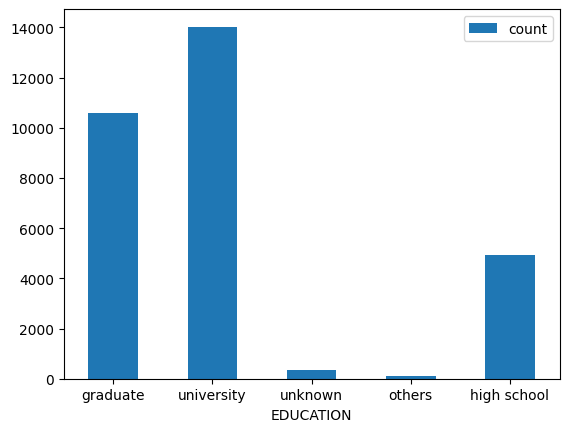

In [ ]:
# Plot EDUCATION
df_all_binned.groupBy('EDUCATION')\
             .count()\
             .toPandas()\
             .plot(x="EDUCATION", y="count", kind="bar", rot=0);

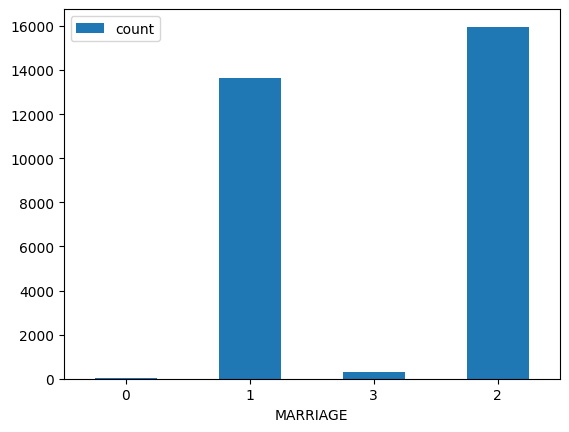

In [ ]:
# Plot MARRIAGE
df_all_binned.groupBy('MARRIAGE')\
             .count()\
             .toPandas()\
             .plot(x="MARRIAGE", y="count", kind="bar", rot=0);

+--------------------------+-----+
|default payment next month|count|
+--------------------------+-----+
|                         0|23364|
|                         1| 6636|
+--------------------------+-----+



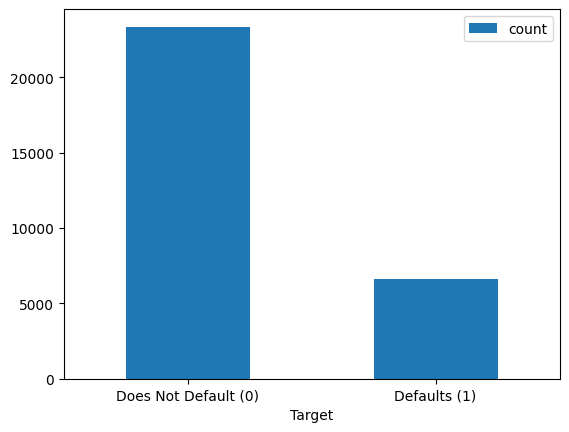

In [ ]:
import matplotlib.pyplot as plt

# Group and aggregate target data
target_cats = df_all_binned.groupBy('default payment next month').count().orderBy('default payment next month')
target_cats.show()

# Plot target data
fig, ax = plt.subplots()
target_cats.toPandas().plot(x='default payment next month', y='count', kind='bar', ax=ax, rot=0)
ax.set_xlabel("Target")
ax.set_xticklabels(['Does Not Default (0)','Defaults (1)']);

Looks like we have a fairly imbalanced dataset.

Let's also visualize the difference in default rate between males and females in this dataset. Group by both default and SEX and visualize the comparison.

+--------------------------+-------+-----+
|default payment next month|SEX_cat|count|
+--------------------------+-------+-----+
|                         0| female|14349|
|                         0|   male| 9015|
|                         1| female| 3763|
|                         1|   male| 2873|
+--------------------------+-------+-----+



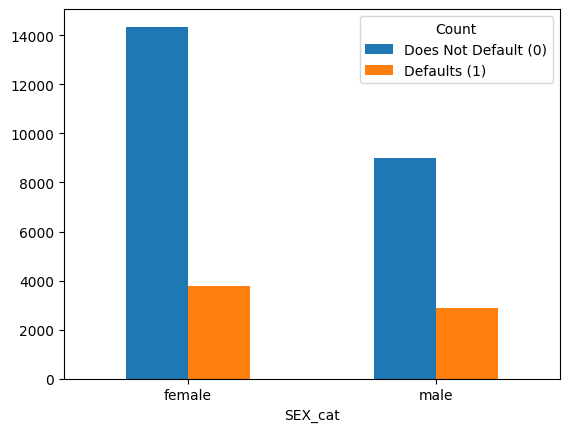

In [ ]:
# Group and aggregate target and sex data
target_by_sex = df_all_binned.groupBy(['default payment next month', 'SEX_cat']).count().orderBy(['default payment next month', 'SEX_cat'])
target_by_sex.show()

# Plot target and sex data
fig, ax = plt.subplots()

target_by_sex.toPandas().pivot(index='SEX_cat', columns='default payment next month')\
               .plot(kind='bar', ax=ax, rot=0)

ax.legend(title="Count", labels=['Does Not Default (0)','Defaults (1)']);

It looks like males have an ever so slightly higher default rate than females, and also represent a smaller proportion of the dataset.


**Data Preprocessing**

-`StringIndexer`

-`OneHotEncoder`

-`VectorAssembler`

In [ ]:
# Import the necessary classes
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Create the string indexers and determine the names of the numeric
# and indexed columns
# (You could write this out for all 3 but we'll use a loop approach)
indexers = []
indexed_features = []
numeric_features = []

for column, data_type in df_all_binned.dtypes:
    if data_type == 'string':
        # Create StringIndexers for columns containing strings
        si = StringIndexer(inputCol=column, outputCol=column+'_num', handleInvalid='keep')
        indexers.append(si)
        # Save the name of the output column to sent to the OHE
        indexed_features.append(si.getOutputCol())
    elif column != "ID" and column != "default payment next month":
        # Unless it's ID (an identifier rather than a genuine feature),
        # append to list of numeric features if the dtype isn't string
        numeric_features.append(column)

print("Indexed string features:", indexed_features, "\n")
print("Numeric features:", numeric_features, "\n")

# Create a OneHotEncoder to encode the indexed string features
ohe = OneHotEncoder(
    inputCols=indexed_features,
    outputCols=[col + '_ohe' for col in indexed_features],
    dropLast=True
)

# Determine the names of the final list of features going into the model
features = numeric_features + ohe.getOutputCols()
print("Final features:", features, "\n")

# Create a VectorAssembler to combine all features
va = VectorAssembler(inputCols=features , outputCol='features')

# Assemble a list of stages that includes all indexers, the one-hot
# encoder, and the vector assembler
stages = indexers + [ohe, va]
print("Stages:", stages)

Indexed string features: ['EDUCATION_num', 'SEX_cat_num', 'MARRIAGE_cat_num', 'EDUCATION_category_num'] 

Numeric features: ['LIMIT_BAL', 'SEX', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] 

Final features: ['LIMIT_BAL', 'SEX', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_num_ohe', 'SEX_cat_num_ohe', 'MARRIAGE_cat_num_ohe', 'EDUCATION_category_num_ohe'] 

Stages: [StringIndexer_7b7a422abe6f, StringIndexer_6dd8595286b0, StringIndexer_766e172f8ef3, StringIndexer_d32ed156c0c7, OneHotEncoder_8c8948e71894, VectorAssembler_498a50ed701b]


Great! Now let's see if that worked. Let's investigate how it transforms your dataset. Put all of the stages in a Pipeline and fit it to your data. Look at the features column. Did you obtain the number of features you expected?

In [ ]:
# Import relevant class
from pyspark.ml.pipeline import Pipeline

# Instantiate a pipeline using stages list
pipe = Pipeline(stages=stages)

# Fit and transform the data using the pipeline, then look at
# the size of the array in the 'features' column
pipe.fit(df_all_binned)\
    .transform(df_all_binned)\
    .head()['features'].size

38

**Fitting Machine Learning Models**

 Now let's go ahead and fit data to different machine learning models. To evaluate these models, you should use the BinaryClassificationEvaluator.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol='prediction',
    labelCol='default payment next month',
    metricName='areaUnderROC'
)

# **Logistic Regression**


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming you have an appropriate evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol='default payment next month',
    predictionCol='prediction',
    metricName='accuracy'
)

# Train-test split
train, test = df_all_binned.randomSplit(weights=[0.8, 0.2], seed=1)

# Instantiate a logistic regression and add to stages
lr = LogisticRegression(
    featuresCol='features',
    labelCol='default payment next month',
    predictionCol='prediction',
    standardization=True
)
lr_stages = stages + [lr]

# Instantiate a new Pipeline with all of the stages
lr_pipe = Pipeline(stages=lr_stages)

# Fit the pipeline on the training data
lr_pipe_fit = lr_pipe.fit(train)

# Transform both train and test data using the pipeline
lr_result_train = lr_pipe_fit.transform(train)
lr_result_test = lr_pipe_fit.transform(test)

# Use evaluator to evaluate performance
print("Accuracy on train:", evaluator.evaluate(lr_result_train))
print("Accuracy on test:", evaluator.evaluate(lr_result_test))


Accuracy on train: 0.811393090803017
Accuracy on test: 0.809928369148759



The model effectively captures 81.1% of the information in predicting whether a client is likely to default or not. The results indicate that there is no evidence of overfitting; the model demonstrates a robust ability to learn and generalize from the underlying patterns in the data.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr

# Create a Spark session
spark = SparkSession.builder.appName("BinaryClassificationMetrics").getOrCreate()

# Assuming you have the lr_result_test DataFrame
lr_result_test.createOrReplaceTempView("lr_result_test")

# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
metrics_query = """
SELECT
    SUM(CASE WHEN prediction = 1 AND `default payment next month` = 1 THEN 1 ELSE 0 END) AS TP,
    SUM(CASE WHEN prediction = 1 AND `default payment next month` = 0 THEN 1 ELSE 0 END) AS FP,
    SUM(CASE WHEN prediction = 0 AND `default payment next month` = 1 THEN 1 ELSE 0 END) AS FN,
    SUM(CASE WHEN prediction = 0 AND `default payment next month` = 0 THEN 1 ELSE 0 END) AS TN
FROM lr_result_test
"""

metrics_df = spark.sql(metrics_query).collect()[0]

# Calculate precision, recall, and F1 score
precision = metrics_df["TP"] / (metrics_df["TP"] + metrics_df["FP"])
recall = metrics_df["TP"] / (metrics_df["TP"] + metrics_df["FN"])
f1_score = 2 * precision * recall / (precision + recall)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: 0.7151898734177216
Recall: 0.2520446096654275
F1 Score: 0.3727322704782848


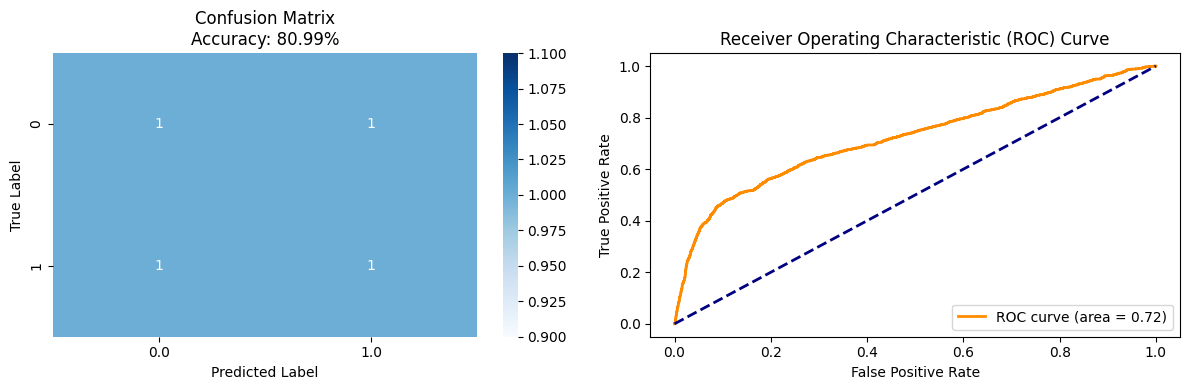

In [ ]:
# Ploting the confusion metric and ROC curves
# Extract probability and true label values
import numpy as np

probs = np.array(lr_result_test.select('probability').collect())
labels = np.array(lr_result_test.select('default payment next month').collect())

# Reshape the arrays to 1D
probs = probs[:, 0, 1]  # Assuming binary classification, adjust accordingly for multi-class
labels = labels[:, 0]

# Plot Confusion Matrix
conf_matrix = lr_result_test.groupBy('default payment next month', 'prediction').count().toPandas()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(pd.crosstab(conf_matrix['default payment next month'], conf_matrix['prediction']), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix\nAccuracy: {:.2%}'.format(accuracy))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
#from pyspark.ml.classification import LogisticRegression

# Train-test split
#train, test = df_all_binned.randomSplit(weights=[0.75, 0.25], seed=1)

# Instantiate a logistic regression and add to stages
#lr = LogisticRegression(
    ##featuresCol='features',
    #labelCol='default payment next month',
    #predictionCol='prediction',
    #standardization=True

#lr_stages = stages + [lr]

# Instantiate a new Pipeline with all of the stages
#lr_pipe = Pipeline(stages=lr_stages)

# Fit the pipeline on the training data
#lr_pipe_fit = lr_pipe.fit(train)

# Transform both train and test data using the pipeline
#lr_result_train = lr_pipe_fit.transform(train)
#lr_result_test = lr_pipe_fit.transform(test)

# Use evaluator to evaluate performance
#print("ROC-AUC on train:", evaluator.evaluate(lr_result_train))
#print("ROC-AUC on test:", evaluator.evaluate(lr_result_test))

The training set and the testing set exhibit a good fit, indicating a lack of overfitting. However, let's explore an alternative model to assess if the area under the curve can be improved, aiming for a value closer to 1. Currently, the value at 0.6 appears suboptimal.

# **Multilayer Perceptron Classifier**


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'features' and 'default' are columns in your DataFrame
# Define the layers for the Multi-Layer Perceptron
layers = [38, 10, 5, 2]

# Instantiate the Multi-Layer Perceptron Classifier
mlp = MultilayerPerceptronClassifier(
    featuresCol='features',
    labelCol='default payment next month',
    predictionCol='prediction',
    layers=layers,
    seed=1
)

# Add the MLP Classifier to the stages
mlp_stages = stages + [mlp]

# Instantiate a new Pipeline with all of the stages
mlp_pipe = Pipeline(stages=mlp_stages)

# Fit the pipeline on the training data
mlp_pipe_fit = mlp_pipe.fit(train)

# Transform both train and test data using the pipeline
mlp_result_train = mlp_pipe_fit.transform(train)
mlp_result_test = mlp_pipe_fit.transform(test)

# Use evaluator to evaluate performance
evaluator = MulticlassClassificationEvaluator(labelCol='default payment next month', predictionCol='prediction', metricName='accuracy')
print("Accuracy on train:", evaluator.evaluate(mlp_result_train))
print("Accuracy on test:", evaluator.evaluate(mlp_result_test))


Accuracy on train: 0.7801216858373673
Accuracy on test: 0.7748229319791528


The Multi-Layer Perceptron (MLP) model demonstrated no significant improvement in deep learning. We can proceed to visualize and analyze this enhancement by plotting the ROC curv

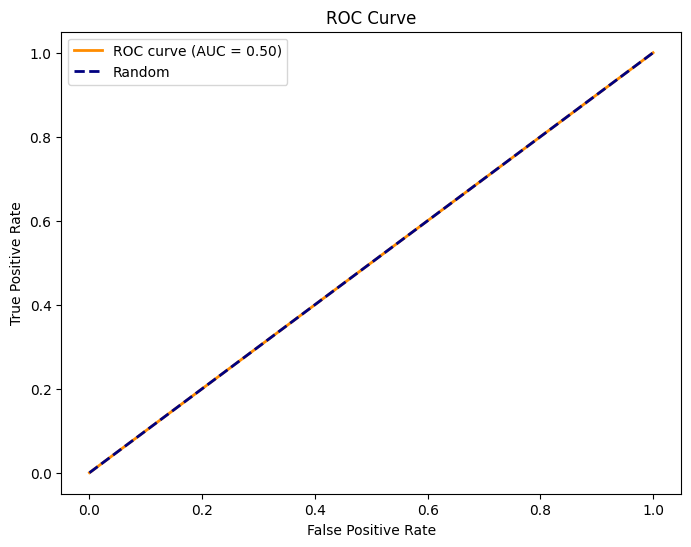

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'prediction' and 'default' are columns in your DataFrame
mlp_result_test_binary = mlp_result_test.withColumn('label_binary', (col('default payment next month') == 1).cast('double'))

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = mlp_result_test_binary.select('label_binary', 'prediction').toPandas()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(df_pandas['label_binary'], df_pandas['prediction'])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()




An AUC of 0.5 in the ROC curve indicates that the model is not effectively learning patterns, and this deficiency is primarily attributed to class imbalance. To address this issue, we plan to oversample the minority class and conduct hyperparameter tuning

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
evaluator = MulticlassClassificationEvaluator(
    labelCol='default payment next month',
    predictionCol='prediction',
    metricName='accuracy'
)

def create_model(df, preprocessing_stages, classifier, param_grid, evaluator):
    # Fit the cross validator model
    stages_with_classifier = preprocessing_stages + [classifier]
    pipe = Pipeline(stages=stages_with_classifier)
    cv = CrossValidator(
        estimator=pipe,
        estimatorParamMaps=param_grid,
        evaluator=evaluator
    )
    model = cv.fit(df)

    # Find and display the best classifier's metric and params
    index_best_clf = np.argmax(model.avgMetrics)
    best_clf_metric = model.avgMetrics[index_best_clf]
    best_clf_params = param_grid[index_best_clf]
    print(f"""
Best {evaluator.getMetricName()}: {best_clf_metric}

Best params: {best_clf_params}
    """)

    # Return the model
    return model

In [ ]:
# Here we're trying a random forest
#This cell may take a long time to run
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features',labelCol='default payment next month')
rf_params = ParamGridBuilder()\
 .addGrid(rf.maxDepth, [5,10])\
 .addGrid(rf.numTrees, [20,100])\
 .build()

rf_model = create_model(df_all_binned, stages, rf, rf_params, evaluator)



Best accuracy: 0.8199833672674631

Best params: {Param(parent='RandomForestClassifier_136c949a0cd9', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='RandomForestClassifier_136c949a0cd9', name='numTrees', doc='Number of trees to train (>= 1).'): 100}
    


In [ ]:


# Assuming df_all_binned is your DataFrame, and stages and rf_params are defined

# Define the random forest classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='default payment next month', predictionCol='prediction')

# Assuming you have an appropriate evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol='default payment next month',
    predictionCol='prediction',
    metricName='accuracy'  # Change this to 'precision', 'recall', 'f1' for other metrics
)

def create_model(df, preprocessing_stages, classifier, param_grid, evaluator):
    # Fit the cross-validator model
    stages_with_classifier = preprocessing_stages + [classifier]
    pipe = Pipeline(stages=stages_with_classifier)
    cv = CrossValidator(
        estimator=pipe,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=5  # Adjust the number of folds as needed
    )
    model = cv.fit(df)

    # Find and display the best classifier's metric and params
    index_best_clf = np.argmax(model.avgMetrics)
    best_clf_metric = model.avgMetrics[index_best_clf]
    best_clf_params = param_grid[index_best_clf]
    print(f"""
Best {evaluator.getMetricName()}: {best_clf_metric}

Best params: {best_clf_params}
    """)

    # Return the model
    return model

# Assuming you have defined stages and rf_params
rf_model = create_model(df_all_binned, stages, rf, rf_params, evaluator)



Best accuracy: 0.8161794413133601

Best params: {Param(parent='RandomForestClassifier_b9a4e7250108', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_b9a4e7250108', name='numTrees', doc='Number of trees to train (>= 1).'): 20}
    
